In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (7,1.65)
fontsize = 11
Fig.config(fontsize, figsize)

In [4]:
dataf = "../../data/simplekv.csv"

In [5]:
data = """simplekv
SIP: Instrumented 303, skipped 2425 locations (aliased=46, exact=2379).
linkedlist
SIP: Instrumented 270, skipped 2317 locations (aliased=167, exact=2150).
btree
SIP: Instrumented 47, skipped 297 locations (aliased=10, exact=287).
map
SIP: Instrumented 302, skipped 2546 locations (aliased=165, exact=2381)."""
print(data)

simplekv
SIP: Instrumented 303, skipped 2425 locations (aliased=46, exact=2379).
linkedlist
SIP: Instrumented 270, skipped 2317 locations (aliased=167, exact=2150).
btree
SIP: Instrumented 47, skipped 297 locations (aliased=10, exact=287).
map
SIP: Instrumented 302, skipped 2546 locations (aliased=165, exact=2381).


In [6]:
data_dict = {}
key = ""
for line in data.split('\n'):
    if not line.startswith('SIP'):
        key = line.strip()
    else:
        data_dict[key] = np.int_(line.replace("SIP: Instrumented ", "")\
                            .replace("skipped ", "")\
                            .replace(" locations (aliased=", ", ")\
                            .replace("exact=", "")\
                            .replace(").", "").split(", "))
data_dict        

{'simplekv': array([ 303, 2425,   46, 2379]),
 'linkedlist': array([ 270, 2317,  167, 2150]),
 'btree': array([ 47, 297,  10, 287]),
 'map': array([ 302, 2546,  165, 2381])}

In [62]:
df = pd.DataFrame(data_dict, index=['Instrumented', 'Skipped', 'Aliased', 'Exact'])
df['btree'] = df['btree'] + df['map']
del df['map']
df = df.T
df.index = rename_index(df, {'simplekv':"KV-Store", 'linkedlist': "Linked List", 'btree': "BTree"})
df

,Instrumented,Skipped,Aliased,Exact
KV-Store,303,2425,46,2379
Linked List,270,2317,167,2150
BTree,349,2843,175,2668


In [63]:
df_exact = df[['Instrumented', 'Exact']]
df_exact

,Instrumented,Exact
KV-Store,303,2379
Linked List,270,2150
BTree,349,2668


In [64]:
df_aliased = df[['Instrumented', 'Aliased']]
df_aliased

,Instrumented,Aliased
KV-Store,303,46
Linked List,270,167
BTree,349,175


Plot saved as `plots/pathfinding/instrumented-separate.png`

Plot saved as `plots/pathfinding/instrumented-separate.png`

Using pdfcrop on `plots/pathfinding/instrumented-separate.png` with command `pdfcrop plots/pathfinding/instrumented-separate.pdf plots/pathfinding/instrumented-separate.pdf`

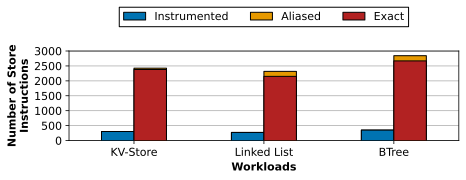

In [65]:
df_first = pd.DataFrame()
df_first['Instrumented'] = df_aliased['Instrumented']
df_first['Aliased'] = df_exact['Exact'] + df_aliased['Aliased']

df_second = pd.DataFrame()
df_second['Instrumented'] = df_aliased['Instrumented']
df_second['Exact'] = df_exact['Exact']

ax = df_first.plot.bar(color=[(0,.45,.7), (.9,.6,0)], **Fig.get_kwargs(legend=""))
ax = df_second.plot.bar(ax=ax, color=[(0,.45,.7), 'firebrick'], **Fig.get_kwargs())
f = Fig(ax)
f.fmt_grid(axis='y')
f.xrot(0)
f.fmt_label('Workloads', 'Number of Store\nInstructions')
ax.set_ylim((0, 3000))
ax.set_yticks(np.arange(0, 3001, 500))
f.fmt_legend(mask=[True, True, False, True])
f.save('instrumented-separate')

Plot saved as `plots/pathfinding/instrumented-stacked.png`

Plot saved as `plots/pathfinding/instrumented-stacked.png`

Using pdfcrop on `plots/pathfinding/instrumented-stacked.png` with command `pdfcrop plots/pathfinding/instrumented-stacked.pdf plots/pathfinding/instrumented-stacked.pdf`

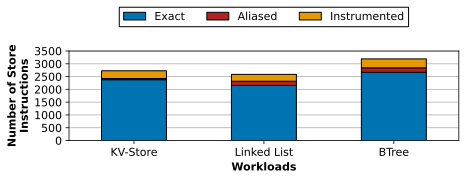

In [67]:
total = df['Instrumented'] + df['Aliased'] + df['Exact']
instr = df['Instrumented']
alias = df['Aliased']
exact = df['Exact']

colors = [(0,.45,.7), 'firebrick', (.9,.6,0)]
ax = exact.plot.bar(color=colors[0], **Fig.get_kwargs(legend=""))
ax = alias.plot.bar(ax=ax, bottom=exact, color=colors[1], **Fig.get_kwargs(legend=""))
ax = instr.plot.bar(ax=ax, bottom=(exact+alias), color=colors[2], **Fig.get_kwargs(legend=""))
f = Fig(ax)
f.xrot(0)
f.fmt_legend()
f.fmt_grid(axis='y')
ax.set_ylim((0,3500))
f.fmt_label('Workloads', 'Number of Store\nInstructions')
_ = ax.set_yticks(np.arange(0, 3501, 500))
f.save('instrumented-stacked')